# HOMEWORK 6

In this homework you are going to use the Harris corner detector to detect the corners of a document. Document detection is a crucial task for many applications, e.g., text recognition, automatic passport reading (at airport gates), etc.

You will also have to design your own feature descriptor in order to localize and distinguish among the 4 document corners.

At the end of this notebook, there are a couple of questions for you to answer.

So let's begin, shall we?

In [21]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<Axes: >, <matplotlib.image.AxesImage at 0x14bba78d0>)

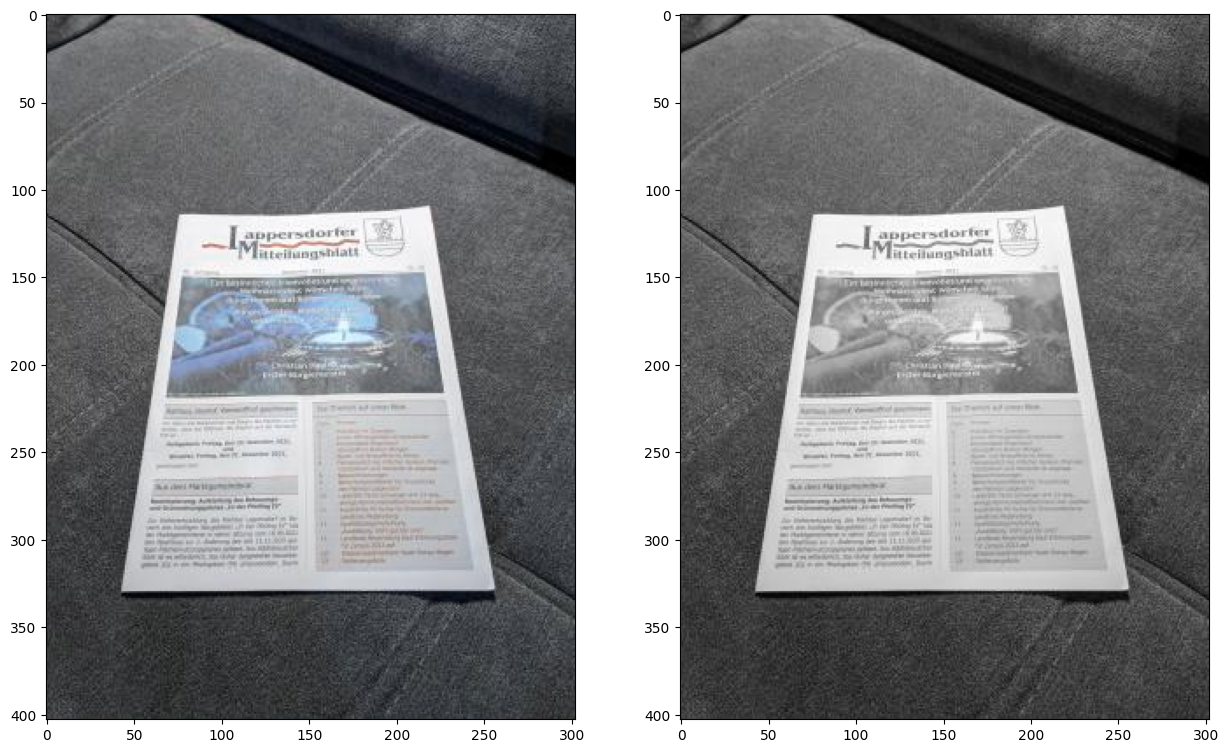

In [26]:
# Let's read the image
img = cv2.imread('../data/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

In [81]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, 2, 3, 0.04)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness = np.maximum(cornerness, 0)

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-4)

(<Axes: >, <matplotlib.image.AxesImage at 0x16ac2d4d0>)

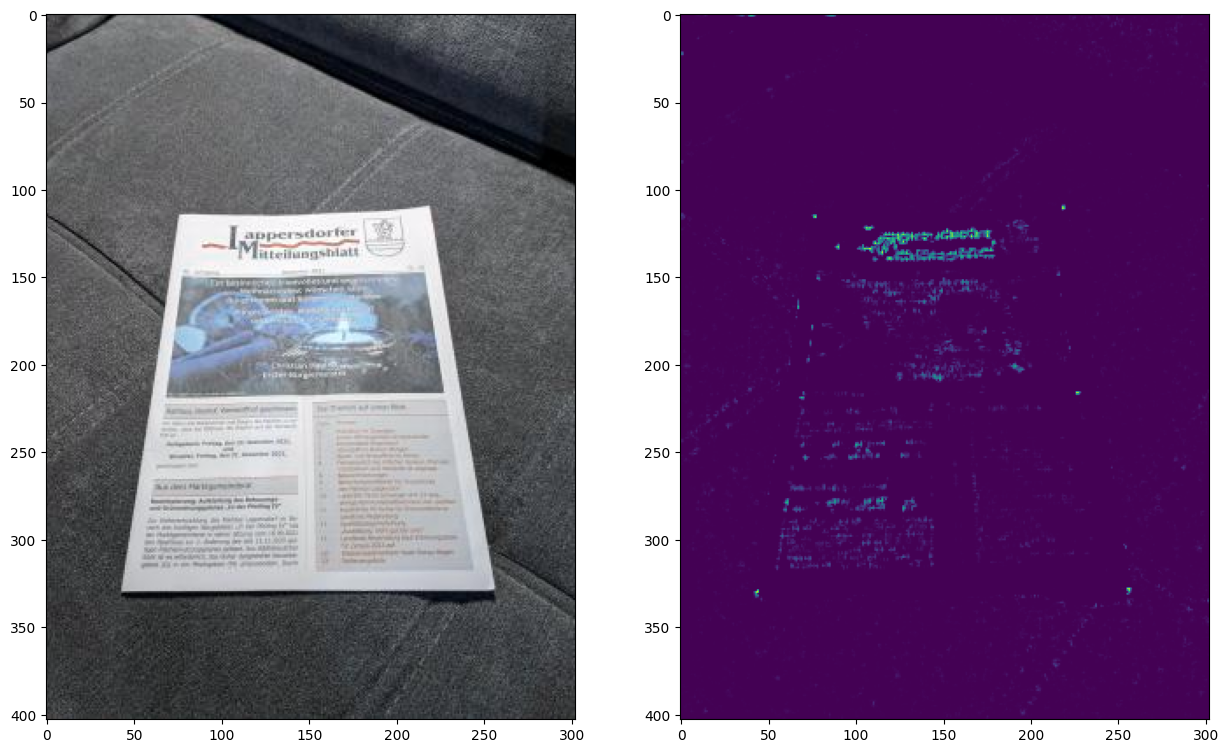

In [82]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.

![Top-left corner](../data/document_descriptor_example.jpg "Top-left corner")

A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

(<Axes: >, <matplotlib.image.AxesImage at 0x16af06b50>)

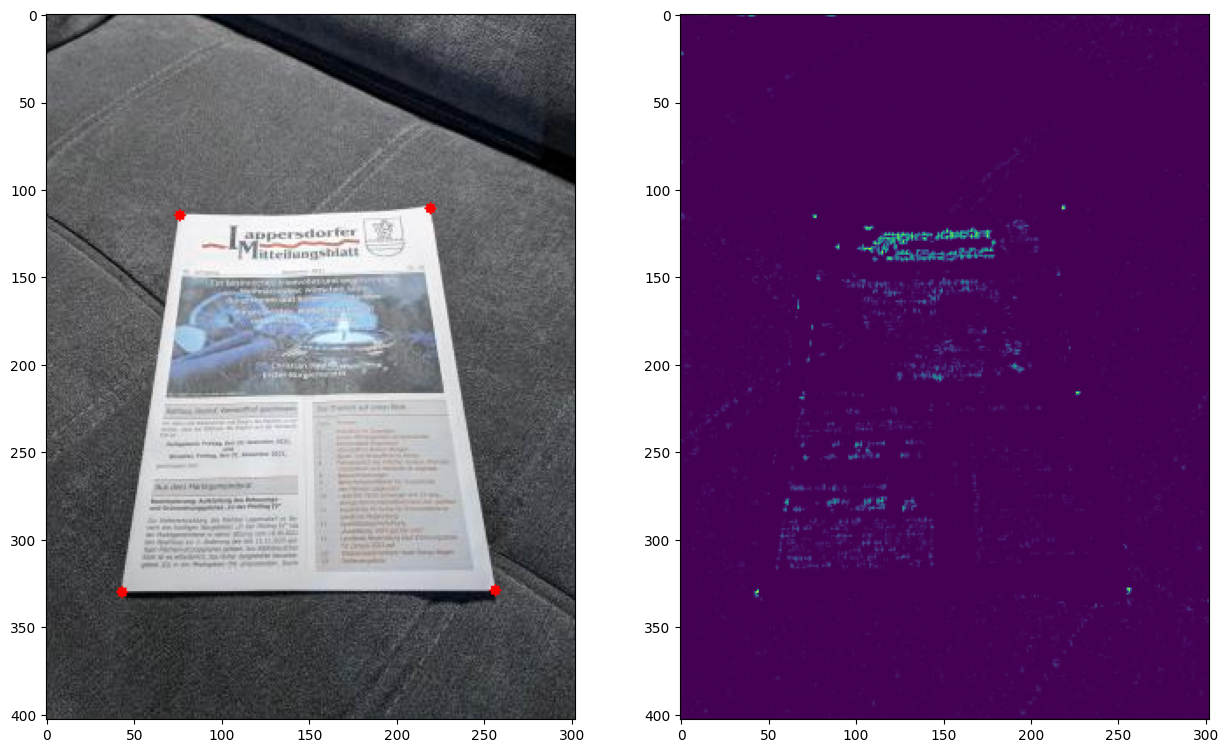

In [83]:
img_c = img.copy()
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size+1:2*quad_size+1]
        quad_bottom_left = block[quad_size+1:2*quad_size+1, 0:quad_size]
        quad_bottom_right = block[quad_size+1:2*quad_size+1, quad_size+1:2*quad_size+1]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        # (your implementation goes here)
        descriptor = np.mean(quad_bottom_left) - np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
            
        # Bottom-left corner
        # (your implementation goes here)
        descriptor = np.mean(quad_top_right) - np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
        
            
        # Bottom-right corner
        # (your implementation goes here)
        descriptor = np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img_c, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img_c, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img_c, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img_c, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?

количество mpx влияет на то сколько мы "деталей" получим в фото. если у нас будет 1mpx, то мы скорее всего получим большую зернист изображения, это приведет к тому что мы получим очень много ложных "углов" или вообще не найдем реальных углов которые искали. Возможно получится их уменьшить и найти реальные углы если применим Canny и следом HoughLines для вычисления "прямых" на картинке и уже на этот результат применить cornerHarris и получим углы и наложим на исходное ихображение (но надо потетстить, это только мысли в слух :)) если у нас будет 12mpx, то мы полочим хорошую детализацию, скорее всего с огромной вероятностью мы точно найдем углы, но мы поторатим ресурсов гораздо больше ресурсов, чем если бы принудительно уменьшили качество изображения и применили алгоритм. все, опять таки, заваист от задача :) но скорее всего я бы смотрел не на одно изображение, а на массив и, например, увидел что в большинстве случаях лист бумаги занимает 80-90% изображения и уже понимал что первым делом принудительно уменьшал качесвто и уже на нем применял алгоритм. возможно правильней увеличит quad_size (так как мы приняли что изображение почти все вото занимает). но это надо потестить, возможно правильней будет и урезать качество и увеличить quad_size. опять таки все упирается в задачу и исходные данные :)

* If we increased the resolution of the camera, what would you change in the current algorithm?

о, я видимо частично ответил на этот вопрос в первом :) выше разрешение -> больше пикселей -> больше тратить ресурсов. Тут, скорее всего, надо будет увеличить blockSize, еще скорее нам нужн будет скорректировать -7, как я понял это значение "угловатости" которые мы отсекаем. так как у нас больше размер то и больше деталей и надо будет его подкоректировать, чтобы не реагировал на "шум". еще заметил что вот тут `cornerness = np.log(cornerness + 1e-4)` (в задаче я просто подобрал его для наилучшего эффекта) надо будте подкоректировать 1e-4, так как оно в последствии влияет на descriptor, но я всетаки склоняюсь к тому что нан надо будет принудительно "ухудшить изображение" чтобы ускорить весь процесс. опять таки все зависит от задачи :)))


Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)